In [185]:
# Install necessary libraries
!pip install numpy matplotlib scikit-learn seaborn tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [186]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# CMPE 597 Sp. Tp. Deep Learning 
## Spring 2025 Assignment 1

## Task 1: no libraries

### PREPROCESSING

In [164]:
#load the datasets
train_img = np.load('./quickdraw_subset_np/train_images.npy')
train_lab = np.load('./quickdraw_subset_np/train_labels.npy')
test_img = np.load('./quickdraw_subset_np/test_images.npy')
test_lab = np.load('./quickdraw_subset_np/test_labels.npy')

num_classes = 5
train_images = train_img.reshape(train_img.shape[0], -1).T / 255.0  # Flatten and normalize
test_images = test_img.reshape(test_img.shape[0], -1).T / 255.0

def one_hot_encode(labels, num_classes):
    labels = labels.astype(int)  # Ensure labels are integers
    return np.eye(num_classes)[labels].T

train_labels = one_hot_encode(train_lab, num_classes)
test_labels = one_hot_encode(test_lab, num_classes)

In [85]:
num_classes=5

print(train_img.shape) # (20000, 28, 28)
print(test_img.shape) # (5000, 28, 28)

(20000, 28, 28)
(5000, 28, 28)


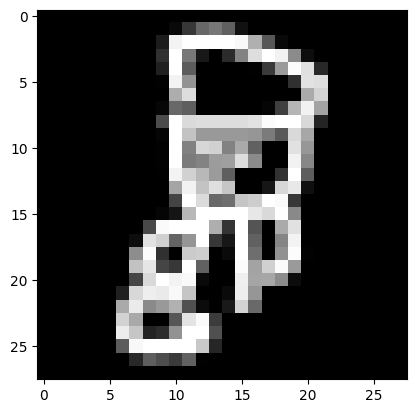

In [47]:
#open the image using matplotlib
plt.imshow(train_img[0], cmap='gray')
plt.show()

In [165]:
class MLP:
    def __init__(self, input_size, layer_specs, momentum=0.9):
        """
        Initialize MLP with custom activation functions for each layer.
        
        Args:
            input_size: Size of input features
            layer_specs: List of tuples [(size1, 'activation1'), (size2, 'activation2'), ...]
                        where last layer is typically (output_size, 'softmax')
            momentum: Momentum parameter for gradient descent
        """
        self.input_size = input_size
        self.layer_specs = layer_specs
        self.num_layers = len(layer_specs)
        self.momentum = momentum

        # Initialize weights, biases, and velocities
        self.weights = []
        self.biases = []
        self.velocities_W = []
        self.velocities_b = []
        
        # Extract layer sizes
        sizes = [input_size] + [size for size, _ in layer_specs]
        
        for i in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i-1]) * 0.01)
            self.biases.append(np.zeros((sizes[i], 1)))
            self.velocities_W.append(np.zeros_like(self.weights[-1]))
            self.velocities_b.append(np.zeros_like(self.biases[-1]))

    def forward(self, X):
        """Forward pass through the network"""
        self.activations = [X]
        self.z = []
        
        for i in range(self.num_layers):
            size, activation_fn = self.layer_specs[i]
            z = np.dot(self.weights[i], self.activations[i]) + self.biases[i]
            self.z.append(z)
            
            # Apply activation function
            if activation_fn == 'relu':
                a = self.relu(z)
            elif activation_fn == 'tanh':
                a = np.tanh(z)
            elif activation_fn == 'sigmoid':
                a = self.sigmoid(z)
            elif activation_fn == 'softmax':
                a = self.softmax(z)
            elif activation_fn == 'linear':
                a = z
            else:
                raise ValueError(f"Unknown activation function: {activation_fn}")
                
            self.activations.append(a)
            
        return self.activations[-1]

    def backward(self, X, y):
        """Backward pass through the network"""
        m = X.shape[1]
        gradients = []
        
        # Output layer gradient
        if self.layer_specs[-1][1] == 'softmax':
            dZ = self.activations[-1] - y
        else:
            # For other output activations, we'd need to compute the appropriate derivative
            raise NotImplementedError("Currently only softmax output is supported")
        
        for i in range(self.num_layers - 1, -1, -1):
            dW = (1 / m) * np.dot(dZ, self.activations[i].T)
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            gradients.append((dW, db))

            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)
                _, activation_fn = self.layer_specs[i-1]
                
                # Compute derivative based on previous layer's activation
                if activation_fn == 'relu':
                    dZ = dA * self.relu_derivative(self.z[i-1])
                elif activation_fn == 'tanh':
                    dZ = dA * (1 - np.tanh(self.z[i-1])**2)
                elif activation_fn == 'sigmoid':
                    sig = self.sigmoid(self.z[i-1])
                    dZ = dA * sig * (1 - sig)
                elif activation_fn == 'linear':
                    dZ = dA
                else:
                    raise ValueError(f"Unknown activation function: {activation_fn}")

        return gradients[::-1]

    def update_parameters(self, gradients, learning_rate):
        """Update parameters with momentum"""
        for i in range(self.num_layers):
            self.velocities_W[i] = self.momentum * self.velocities_W[i] + (1 - self.momentum) * gradients[i][0]
            self.velocities_b[i] = self.momentum * self.velocities_b[i] + (1 - self.momentum) * gradients[i][1]
            
            self.weights[i] -= learning_rate * self.velocities_W[i]
            self.biases[i] -= learning_rate * self.velocities_b[i]

    # Activation functions
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    # Loss functions
    def categorical_cross_entropy(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

In [89]:
def compute_accuracy(y_true, y_pred):
    """Helper function to compute accuracy"""
    correct = np.sum(np.argmax(y_true, axis=0) == np.argmax(y_pred, axis=0))
    return correct / y_true.shape[1] * 100

In [171]:
# Initialize tracking variables
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

input_size = train_images.shape[0]
# Define network architecture with explicit activations
layer_specs = [
    (128, 'relu'),    # First hidden layer: 128 units with ReLU
    (64, 'relu'),    # Second hidden layer: 64 units with Tanh
    (num_classes, 'softmax')  # Output layer with softmax
]

# Initialize the MLP with the new architecture
mlp = MLP(input_size, layer_specs, momentum=0.9)

# Training parameters
learning_rate = 0.01
epochs = 30
batch_size = 32


In [172]:
for epoch in range(epochs):
    epoch_loss = 0
    train_epoch_loss=0
    num_batches = train_images.shape[1] // batch_size

    # Shuffle the training data each epoch
    permutation = np.random.permutation(train_images.shape[1])
    shuffled_train_images = train_images[:, permutation]
    shuffled_train_labels = train_labels[:, permutation]

    for i in range(0, train_images.shape[1], batch_size):
        X_batch = shuffled_train_images[:, i:i+batch_size]
        y_batch = shuffled_train_labels[:, i:i+batch_size]

        # Forward pass
        y_pred = mlp.forward(X_batch)

        # Compute loss
        loss = mlp.categorical_cross_entropy(y_batch, y_pred)
        epoch_loss += loss

        # Compute test loss
        test_loss = mlp.categorical_cross_entropy(test_labels, y_test_pred)
        train_epoch_loss += test_loss
        

        # Backward pass
        gradients = mlp.backward(X_batch, y_batch)

        # Update parameters
        mlp.update_parameters(gradients, learning_rate)

    # Compute average loss for the epoch
    epoch_loss /= num_batches
    train_losses.append(epoch_loss)
    train_epoch_loss /= num_batches
    test_losses.append(train_epoch_loss)

    # Compute accuracy on training set
    y_train_pred = mlp.forward(train_images)
    train_acc = compute_accuracy(train_labels, y_train_pred)
    train_accuracies.append(train_acc)

    # Compute accuracy on test set
    y_test_pred = mlp.forward(test_images)
    test_acc = compute_accuracy(test_labels, y_test_pred)
    test_accuracies.append(test_acc)

    # Calculate additional metrics
    y_test_pred_classes = np.argmax(y_test_pred, axis=0)
    y_test_true_classes = np.argmax(test_labels, axis=0)

    accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
    precision = precision_score(y_test_true_classes, y_test_pred_classes, average="macro")
    recall = recall_score(y_test_true_classes, y_test_pred_classes, average="macro")
    f1 = f1_score(y_test_true_classes, y_test_pred_classes, average="macro")

    # Print results for each epoch
    print(f"Epoch {epoch}: "
      f"Train Loss = {epoch_loss:.4f}, "
      f"Test Loss = {test_loss:.4f}, "
      f"Train Acc = {train_acc:.2f}%, "
      f"Test Acc = {test_acc:.2f}%, "
      f"Precision = {precision:.2f}, "
      f"Recall = {recall:.2f}, "
      f"F1 = {f1:.2f}")

/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0: Train Loss = 1.6094, Test Loss = 0.5052, Train Acc = 26.98%, Test Acc = 27.24%, Precision = 0.12, Recall = 0.27, F1 = 0.15


/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Train Loss = 1.6089, Test Loss = 1.6092, Train Acc = 35.25%, Test Acc = 35.52%, Precision = 0.40, Recall = 0.36, F1 = 0.24


/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Train Loss = 1.6076, Test Loss = 1.6084, Train Acc = 51.18%, Test Acc = 51.32%, Precision = 0.32, Recall = 0.51, F1 = 0.39


/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Train Loss = 1.5992, Test Loss = 1.6059, Train Acc = 50.64%, Test Acc = 50.64%, Precision = 0.42, Recall = 0.51, F1 = 0.40
Epoch 4: Train Loss = 1.4490, Test Loss = 1.5821, Train Acc = 51.83%, Test Acc = 51.68%, Precision = 0.63, Recall = 0.52, F1 = 0.43
Epoch 5: Train Loss = 1.0877, Test Loss = 1.2518, Train Acc = 65.48%, Test Acc = 65.80%, Precision = 0.65, Recall = 0.66, F1 = 0.62
Epoch 6: Train Loss = 0.8845, Test Loss = 0.9372, Train Acc = 69.01%, Test Acc = 68.90%, Precision = 0.70, Recall = 0.69, F1 = 0.66
Epoch 7: Train Loss = 0.8002, Test Loss = 0.8456, Train Acc = 72.95%, Test Acc = 72.82%, Precision = 0.72, Recall = 0.73, F1 = 0.72
Epoch 8: Train Loss = 0.7378, Test Loss = 0.7702, Train Acc = 75.08%, Test Acc = 74.70%, Precision = 0.75, Recall = 0.75, F1 = 0.74
Epoch 9: Train Loss = 0.6918, Test Loss = 0.7243, Train Acc = 77.11%, Test Acc = 76.16%, Precision = 0.76, Recall = 0.76, F1 = 0.76
Epoch 10: Train Loss = 0.6595, Test Loss = 0.6875, Train Acc = 77.99%, Test 

### Results

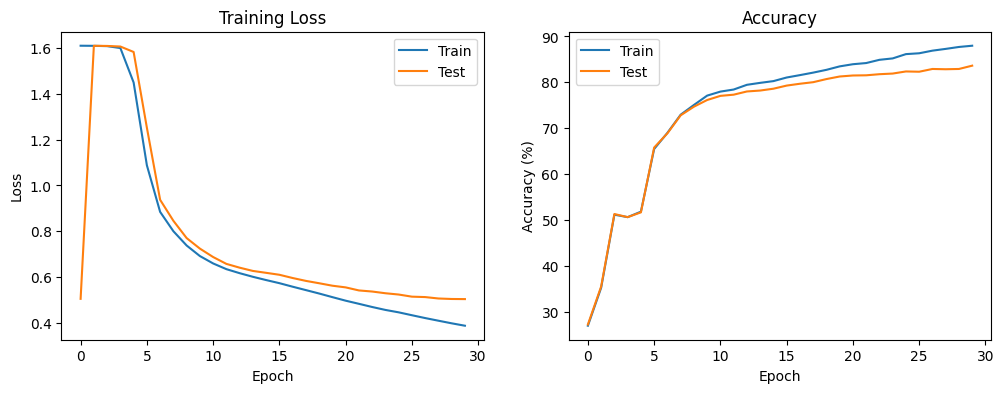

In [173]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

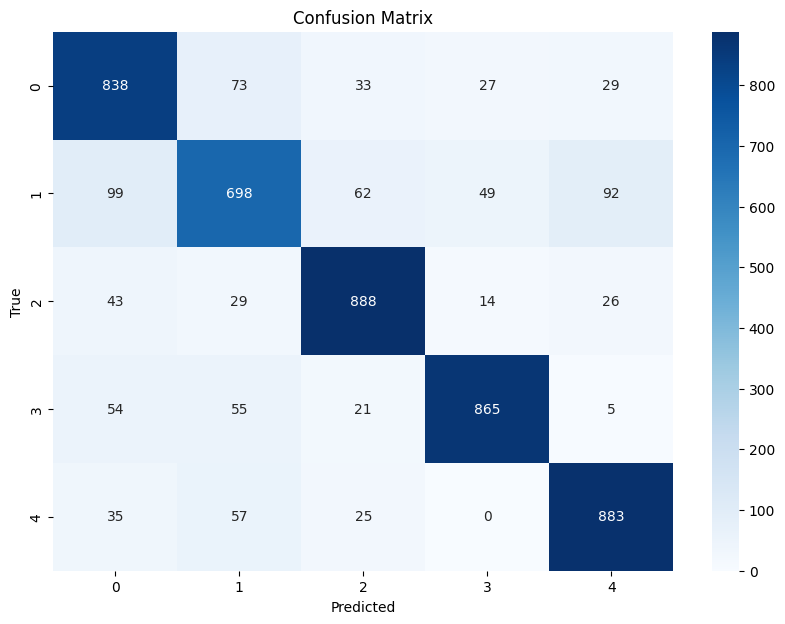

In [143]:
#show confusion matrix
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [144]:
#print the classification report
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=[str(i) for i in range(num_classes)]))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1000
           1       0.77      0.70      0.73      1000
           2       0.86      0.89      0.88      1000
           3       0.91      0.86      0.88      1000
           4       0.85      0.88      0.87      1000

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



# Task 1: with libraries

In [178]:
train_images = train_img.astype('float32') / 255.0
test_images = test_img.astype('float32') / 255.0

# Flatten images
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Convert labels to categorical format
train_labels = keras.utils.to_categorical(train_lab, num_classes)
test_labels = keras.utils.to_categorical(test_lab, num_classes)


In [179]:
# Define the MLP model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(28*28,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
# Define the SGD optimizer with momentum
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and store the history
history = model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/30
625/625 [==============================] - 1s 1ms/step - loss: 0.7074 - accuracy: 0.7466 - val_loss: 0.5903 - val_accuracy: 0.7942
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.5100 - accuracy: 0.8227 - val_loss: 0.5056 - val_accuracy: 0.8288
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.4242 - accuracy: 0.8540 - val_loss: 0.4795 - val_accuracy: 0.8324
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3605 - accuracy: 0.8758 - val_loss: 0.4572 - val_accuracy: 0.8414
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3102 - accuracy: 0.8957 - val_loss: 0.4575 - val_accuracy: 0.8412
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2656 - accuracy: 0.9089 - val_loss: 0.4750 - val_accuracy: 0.8454
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2258 - accuracy: 0.9258 - val_loss: 0.4787 - val_accuracy: 0.8526
Epoch 

157/157 - 0s - loss: 0.9707 - accuracy: 0.8478 - 100ms/epoch - 636us/step
Test accuracy: 0.8478


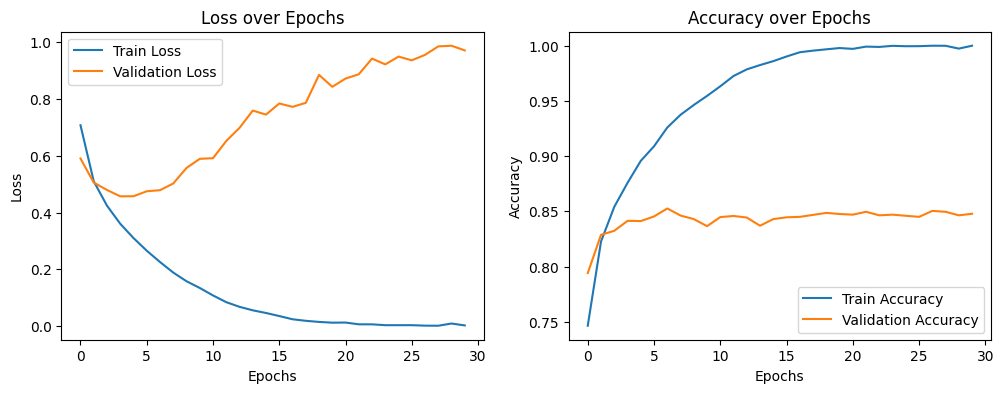

In [181]:

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [149]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


157/157 [==============================] - 0s 565us/step


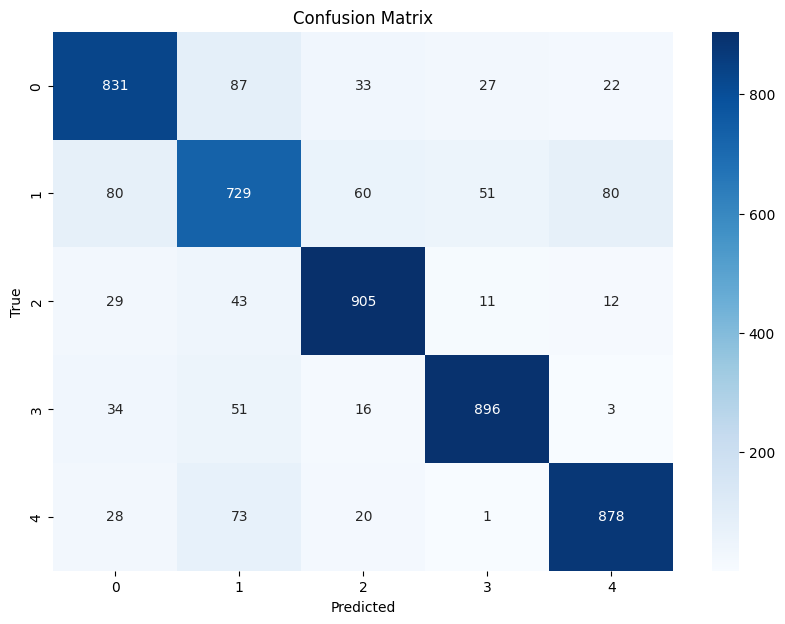

In [183]:
#get a graph of the accuracy of the model

# Plot confusion matrix
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [184]:

# Calculate additional metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average="macro")
recall = recall_score(y_true_classes, y_pred_classes, average="macro")
f1 = f1_score(y_true_classes, y_pred_classes, average="macro")
roc_auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')
average_precision = average_precision_score(test_labels, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
ROC AUC: 0.97


In [182]:
#classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(num_classes)]))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1000
           1       0.75      0.70      0.72      1000
           2       0.90      0.88      0.89      1000
           3       0.89      0.88      0.88      1000
           4       0.86      0.90      0.88      1000

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

